#### Imports

In [44]:
# Libraries
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn import metrics
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf
import re

import polars as pl

import matplotlib.pyplot as plt

In [45]:
from sklearn.decomposition   import PCA
from sklearn.linear_model    import LogisticRegression
from sklearn.metrics         import accuracy_score, classification_report, confusion_matrix, f1_score
from sklearn.model_selection import GridSearchCV, ParameterGrid, RepeatedKFold, train_test_split
from sklearn.pipeline        import Pipeline
from sklearn.preprocessing   import StandardScaler
from sklearn.svm             import SVC

#### Daten einlesen

In [60]:
df = pd.read_csv('pd_speech_features.csv')


df.columns = df.iloc[0]  
df = df[1:]
df.drop(['id', 'gender'], axis=1)
X = df.drop(['class'], axis=1)
y = df['class']

#### Train-Test-Split und Pipeline

In [90]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
pca = PCA(n_components=.95)
steps = [('scaler', scaler),
         ('pca', pca),
         ('classifier', LogisticRegression(max_iter=1000))]

pipe = Pipeline(steps)

In [91]:
df

,id,gender,PPE,DFA,RPDE,numPulses,numPeriodsPulses,meanPeriodPulses,stdDevPeriodPulses,locPctJitter,...,tqwt_kurtosisValue_dec_28,tqwt_kurtosisValue_dec_29,tqwt_kurtosisValue_dec_30,tqwt_kurtosisValue_dec_31,tqwt_kurtosisValue_dec_32,tqwt_kurtosisValue_dec_33,tqwt_kurtosisValue_dec_34,tqwt_kurtosisValue_dec_35,tqwt_kurtosisValue_dec_36,class
1,0,1,0.85247,0.71826,0.57227,240,239,0.00806353,8.68E-05,0.00218,...,1.562,2.6445,3.8686,4.2105,5.1221,4.4625,2.6202,3.0004,18.9405,1
2,0,1,0.76686,0.69481,0.53966,234,233,0.008258256,7.31E-05,0.00195,...,1.5589,3.6107,23.5155,14.1962,11.0261,9.5082,6.5245,6.3431,45.178,1
3,0,1,0.85083,0.67604,0.58982,232,231,0.00833959,6.04E-05,0.00176,...,1.5643,2.3308,9.4959,10.7458,11.0177,4.8066,2.9199,3.1495,4.7666,1
4,1,0,0.41121,0.79672,0.59257,178,177,0.010857733,0.000182739,0.00419,...,3.7805,3.5664,5.2558,14.0403,4.2235,4.6857,4.846,6.265,4.0603,1
5,1,0,0.3279,0.79782,0.53028,236,235,0.008161574,0.002668863,0.00535,...,6.1727,5.8416,6.0805,5.7621,7.7817,11.6891,8.2103,5.0559,6.1164,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
752,250,0,0.80903,0.56355,0.28385,417,416,0.004626942,5.22E-05,0.00064,...,3.0706,3.019,3.1212,2.4921,3.5844,3.54,3.3805,3.2003,6.8671,0
753,250,0,0.16084,0.56499,0.59194,415,413,0.004549703,0.000219994,0.00143,...,1.9704,1.7451,1.8277,2.4976,5.2981,4.2616,6.3042,10.9058,28.417,0
754,251,0,0.88389,0.72335,0.46815,381,380,0.005069271,0.000102654,0.00076,...,51.5607,44.4641,26.1586,6.3076,2.8601,2.5361,3.5377,3.3545,5.0424,0
755,251,0,0.83782,0.7489,0.49823,340,339,0.005679019,5.51E-05,0.00092,...,19.1607,12.8312,8.9434,2.2044,1.9496,1.9664,2.6801,2.8332,3.7131,0


#### Gridsearch

In [110]:
from sklearn.ensemble import RandomForestClassifier

param_grid = [
    {
        'pca__n_components': [5, 15, 30, 45],
        'classifier': [LogisticRegression(max_iter=10000)],
        'classifier__C': [0.1, 1, 10]
    },
    {
        'pca__n_components': [5, 15, 30, 45],
        'classifier': [RandomForestClassifier()],
        'classifier__n_estimators': [50, 100, 200],
        'classifier__max_depth': [None, 10, 20]
    },
    {
        'pca__n_components': [5, 15, 30, 45],
        'classifier': [SVC()],
        'classifier__C': [0.1, 1, 10],
        'classifier__kernel': ['linear', 'rbf']
    }
]

gridpoints = len(ParameterGrid(param_grid))

print('Anzahl Parameterkombinationen: ', gridpoints)

Anzahl Parameterkombinationen:  72


In [111]:
n_splits  = 5
n_repeats = 10
splits    = n_splits * n_repeats   # Anzahl Durhläufe pro Parameterkombination

cv = RepeatedKFold(n_splits= n_splits, n_repeats= n_repeats)

In [112]:
# https://scikit-learn.org/1.5/modules/generated/sklearn.model_selection.GridSearchCV.html

import time
start = time.time()

search = GridSearchCV(pipe, param_grid, n_jobs= -1, scoring= 'accuracy', cv= cv, refit= True)
search.fit(X_train, y_train)

print('Anzahl Parameterkombis:', gridpoints)
print('Anzahl Training-Validation-Splits:', splits)
print('Anzahl Durchläufe:', gridpoints*splits)
end = time.time()
print('Dauer:', round(end - start), 'Sekunden')

print("Best parameter (CV score=%0.3f):" % search.best_score_)
print(search.best_params_)

C:\uni\5. sem\dmml\.venv\Lib\site-packages\numpy\ma\core.py:2846: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Anzahl Parameterkombis: 72
Anzahl Training-Validation-Splits: 50
Anzahl Durchläufe: 3600
Dauer: 301 Sekunden
Best parameter (CV score=0.882):
{'classifier': SVC(probability=True), 'classifier__C': 10, 'classifier__kernel': 'rbf', 'pca__n_components': 45}


In [113]:
print(search.best_params_)

{'classifier': SVC(probability=True), 'classifier__C': 10, 'classifier__kernel': 'rbf', 'pca__n_components': 45}


In [114]:
search.cv_results_

{'mean_fit_time': array([ 0.10565997,  0.09362271,  0.09769874,  0.10308179,  0.09055759,
         0.0938211 ,  0.09805018,  0.10404118,  0.09111256,  0.0949038 ,
         0.09884942,  0.10583149,  0.14047254,  0.15134129,  0.17369948,
         0.19134884,  0.18665645,  0.20929883,  0.25361053,  0.28194436,
         0.28842701,  0.33481621,  0.44667568,  0.52874126,  0.1380764 ,
         0.14846792,  0.17109714,  0.18768041,  0.18285789,  0.20432251,
         0.24628761,  0.27240416,  0.27939058,  0.32657923,  0.4328678 ,
         0.50564173,  0.13901128,  0.14973551,  0.17187956,  0.18985841,
         0.18483066,  0.20492175,  0.24686974,  0.27733068,  0.28049718,
         0.3274117 ,  0.43874714,  0.51686993,  0.11818932,  0.13182152,
         0.15151277,  0.16143016,  0.10324625,  0.10929215,  0.11552678,
         0.12537694,  0.22896778,  0.4180696 ,  0.75432791,  0.94852639,
         0.10780402,  0.11037827,  0.11696486,  0.1258523 , 10.06412668,
         5.35437648, 10.94103065, 

#### Confusion Matrix und Accuracy für die Testdaten

In [115]:
y_test = y_test.astype(int)

y_test_pred = search.best_estimator_.predict(X_test)

y_test_pred = y_test_pred.astype(int)
print('Confusion Matrix(test):')
print(confusion_matrix(y_test, y_test_pred))   # sklearn.metrics.confusion_matrix(y_true, y_pred,....
print('Accuracy(test):', round(accuracy_score(y_test, y_test_pred)*100),'%')

Confusion Matrix(test):
[[ 25  13]
 [  5 109]]
Accuracy(test): 88 %


#### Verwendet die optimierte Pipeline, um eine ROC-Kurve (Testdaten) zu erstellen.

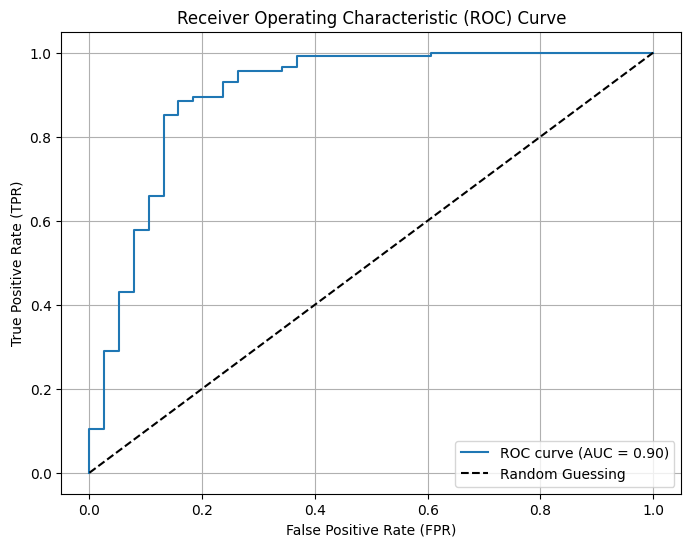

In [116]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

#Chatgpt Anfang
 
y_test = y_test.astype(int)
# Die optimierte Pipeline aus der GridSearch verwenden
best_model = search.best_estimator_
 
# Vorhersagen auf Testdaten (Wahrscheinlichkeiten)
y_prob = best_model.predict_proba(X_test)[:, 1]  # Wahrscheinlichkeiten für Klasse 1
 
# ROC-Kurve berechnen
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = roc_auc_score(y_test, y_prob)
 
# Plot der ROC-Kurve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--', label="Random Guessing")
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid()
plt.show()

#Chatgpt Ende

#### Berechnet TPR, FPR, sowie F1-score für die Thresholds -0.5 bis 1.5 in Schritten von 0.1.

In [117]:
# Chatgpt Anfang
thresholds = np.arange(-0.5, 1.6, 0.1)
tpr = [np.sum((y_prob > t) & (y_test == 1)) / np.sum(y_test == 1) for t in thresholds]
fpr = [np.sum((y_prob > t) & (y_test == 0)) / np.sum(y_test == 0) for t in thresholds]
f1 = [f1_score(y_test, y_prob > t) for t in thresholds]


for t, tp, f, f1_ in zip(thresholds, tpr, fpr, f1):
    print(f"Threshold: {t:.1f} | TPR: {tp:.2f} | FPR: {f:.2f} | F1-Score: {f1_:.2f}")
# Chatgpt Ende

Threshold: -0.5 | TPR: 1.00 | FPR: 1.00 | F1-Score: 0.86
Threshold: -0.4 | TPR: 1.00 | FPR: 1.00 | F1-Score: 0.86
Threshold: -0.3 | TPR: 1.00 | FPR: 1.00 | F1-Score: 0.86
Threshold: -0.2 | TPR: 1.00 | FPR: 1.00 | F1-Score: 0.86
Threshold: -0.1 | TPR: 1.00 | FPR: 1.00 | F1-Score: 0.86
Threshold: -0.0 | TPR: 1.00 | FPR: 1.00 | F1-Score: 0.86
Threshold: 0.1 | TPR: 1.00 | FPR: 0.68 | F1-Score: 0.90
Threshold: 0.2 | TPR: 0.99 | FPR: 0.53 | F1-Score: 0.91
Threshold: 0.3 | TPR: 0.99 | FPR: 0.50 | F1-Score: 0.92
Threshold: 0.4 | TPR: 0.98 | FPR: 0.37 | F1-Score: 0.93
Threshold: 0.5 | TPR: 0.96 | FPR: 0.34 | F1-Score: 0.93
Threshold: 0.6 | TPR: 0.96 | FPR: 0.29 | F1-Score: 0.93
Threshold: 0.7 | TPR: 0.91 | FPR: 0.24 | F1-Score: 0.92
Threshold: 0.8 | TPR: 0.86 | FPR: 0.16 | F1-Score: 0.90
Threshold: 0.9 | TPR: 0.69 | FPR: 0.13 | F1-Score: 0.80
Threshold: 1.0 | TPR: 0.00 | FPR: 0.00 | F1-Score: 0.00
Threshold: 1.1 | TPR: 0.00 | FPR: 0.00 | F1-Score: 0.00
Threshold: 1.2 | TPR: 0.00 | FPR: 0.00 | F

#### Fügt die berechneten Punktepaare TPR und FPR in das Diagramm mit der ROC-Kurve ein.

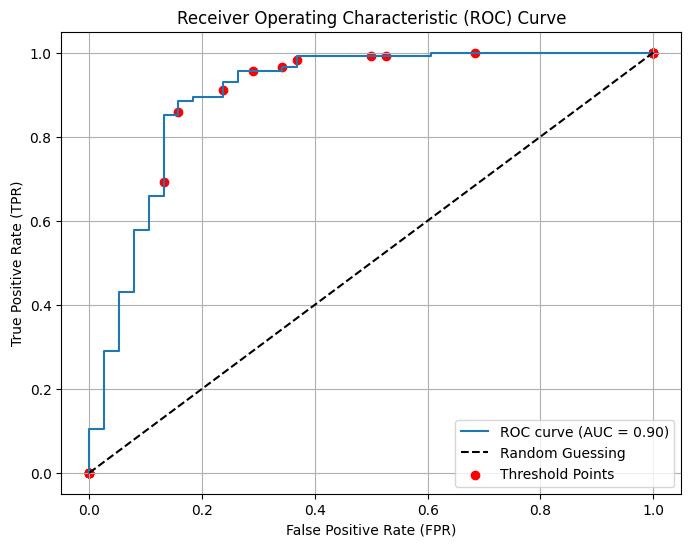

In [118]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt
import numpy as np

# Chatgpt Anfang
# Convert y_test to integers
y_test = y_test.astype(int)

# Use the optimized pipeline from GridSearch
best_model = search.best_estimator_

# Predict probabilities for the test data
y_prob = best_model.predict_proba(X_test)[:, 1]  # Probabilities for class 1

# Compute ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = roc_auc_score(y_test, y_prob)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--', label="Random Guessing")

# Calculate TPR, FPR for thresholds -0.5 to 1.5 in steps of 0.1
thresholds = np.arange(-0.5, 1.6, 0.1)
tpr_points = [np.sum((y_prob > t) & (y_test == 1)) / np.sum(y_test == 1) for t in thresholds]
fpr_points = [np.sum((y_prob > t) & (y_test == 0)) / np.sum(y_test == 0) for t in thresholds]

# Add TPR and FPR points to the ROC curve
plt.scatter(fpr_points, tpr_points, color='red', label='Threshold Points')

plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid()
plt.show()
# Chatgpt Ende